<a href="https://colab.research.google.com/github/waveology/kitchen/blob/main/05_introducci%C3%B3n_nco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<html><img src="https://owncloud.aemet.es/index.php/s/lwiFbCGBRAJHlF7/download?path=%2F&files=logo.png"></html>


* **Autor:** Ernesto Barrera
* **Institución:** AEMET
---

#Introducción a NCO (netCDF Operators)

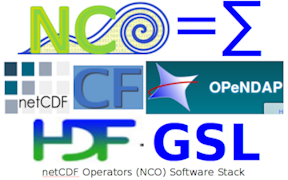

* [Web del proyecto](https://nco.sourceforge.net/)
* Guía de usuario:  [PDF](https://nco.sourceforge.net/nco.pdf)   /   [HTML](https://nco.sourceforge.net/nco.html)
* [Código fuente](https://nco.sourceforge.net/#Source)







* **¿Qué es NCO?** Un pequeño conjunto de operadores que actúan sobre ficheros en formato NetCDF.

* **¿Cómo se usa NCO?** Los operadores se invocan en línea de comandos con diversos modificadores.

* **¿Cuándo usar NCO?** Cuando se requiera el preproceso eficiente en memoria de datos en formato NetCDF.

* **¿Por qué NCO?** Porque simplifica la operativa al realizar multitud de operaciones con unos pocos operadores.

##Operadores

Funciones de los operadores

* Aritmética: **ncap2**
* Editor de atributos: **ncatted**
* Operador binario: **ncbo**
* Generador de climatologías: **ncclimo**
* Estadística de ensembles: **nces**
* Concatenador de ensembles: **ncecat**
* Interpolación: **ncflint**
* Cajón de sastre (kitchen sink): **ncks**
* Permuta y empaquetado: **ncpdq**
* Promedio de registros: **ncra**
* Concatenador de registros: **ncrcat**
* Remapeador: **ncremap**
* Renombrador: **ncrename**
* Promedios ponderados: **ncwa**

##Instalación

* Hay más de una forma de instalar NCO
* Para este noetbook usaremos el repositorio Conda de Colab


In [ ]:
# Instala conda en Colab
# En Colab suele ser necesario ejecutar esta celda
# dos veces para completar el reinicio del entorno
# --------------------------------------------------------
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
# Instala NCO
# -----------------
condacolab.check()
!mamba install -q nco

In [ ]:
# Especificación de la ruta de udunits (Colab)
# ---------------------------------------------
import os
os.environ['UDUNITS2_XML_PATH'] = '/usr/local/share/udunits/udunits2.xml'

##Descarga de datos

* Descargaremos un fichero con datos del reanálisis ERA5 para experimentar con NCO

* Los reanálisis ERA5 están disponibles gratuitamente en el [portal de C3S de Copernicus](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=form)

In [ ]:
ifile = 'era5_pl_t_2020_europa_025.rar'
!wget -q --no-check-certificate https://owncloud.aemet.es/index.php/s/yKz7WbTgcUQyuQW/download -O {ifile} && unrar -o+ e {ifile} && rm -f {ifile}
!mv era5_pl_t_2020_europa_025.nc era5.nc

##Operador **`nkcs`** (cajón de sastre)

###Inspección de un fichero

In [ ]:
# Información general sobre el fichero
# -------------------------------------
!ncks era5.nc | head -n 50

###Inspección de variables/dimensiones

In [ ]:
# Información sobre la dimensión latitud
# ---------------------------------------
!ncks -v latitude era5.nc  | head -n 50

In [ ]:
# Información sobre múltiples dimensiones
# ---------------------------------------
!ncks -v latitude,longitude,time  era5.nc  | head -n 50

###Extracción de subconjuntos

In [ ]:
# Extrae valores de la temperatura para:
# - las 10 primeras latitudes
# - las 10 primeras longitudees
# - los dos primeros niveles verticales
# ------------------------------------------------------
!ncks -v t -d latitude,0,9 -d longitude,0,9 -d level,0,1 era5.nc | head -n 50

###Volcado  a otro fichero (índices)

In [ ]:
# Volcado de los niveles de presión a un nuevo fichero
# ---------------------------------------------------------
!ncks -v level  era5.nc -O  resultado.nc

# Comprobación
# ---------------------------------
!ncks resultado.nc   | head -n 20

In [ ]:
# Volcado a otro fichero de la temperatura de un nivel (1000 hPa) en un recorte del área
# ---------------------------------------------------------------------------------------
!ncks -v t -d level,36 -d longitude,10,20 -d latitude,10,20 era5.nc -O  resultado.nc

# Comprobación
# ------------------------------
!ncks resultado.nc | head -n 55

###Volcado  a otro fichero (valores)

* Para realizar la misma operación especificando valores en lugar de índices se usa el comando **`ncea`**

* La sintaxis de los modificadores se mantiene

In [ ]:
# Volcado a otro fichero de la temperatura en el nivel de 500 hPa en una ventana
# de latitud [30N, 40N] y longitud [-30,-20]
# ---------------------------------------------------------------------------------------
!ncea -v t -d level,500.0 -d longitude,-30,-20 -d latitude,30,40 era5.nc -O  resultado.nc

# Comprobación
# ------------------------------
!ncks resultado.nc | head -n 50

## Operador ncrcat (concatenador)

###Concatenación de tiempos

* Separamos los datos del año 2020 en dos ficheros semestrales con **`ncks`**

In [ ]:
!rm -f enero_junio.nc* julio_diciembre.nc* resultado.nc*

In [ ]:
# El fichero era5.nc contiene un dato por cada mes
# ------------------------------------------------
!ncks -v time era5.nc

# Separamos los primeros 6 meses en un fichero
# ---------------------------------------------
!ncks -d time,2020-01-01,2020-06-30 era5.nc -O  dumb.nc

# Hacemos la dimensión temporal ilimitada
# -------------------------------------------
!ncks --mk_rec_dmn time dumb.nc -O enero_junio.nc

# Separamos los últimos 6 meses en otro fichero
# -----------------------------------------------
!ncks -d time,2020-07-01,2020-12-31 era5.nc -O dumb.nc

# Hacemos la dimensión temporal ilimitada
# -------------------------------------------
!ncks --mk_rec_dmn time dumb.nc -O julio_diciembre.nc

# Comprobación
# ------------------------------
!ncks -v time enero_junio.nc
!ncks -v time julio_diciembre.nc

* Y a continuación los volvemos a concatenar con **`ncrcat`**

In [ ]:
# El fichero era5.nc contiene un dato por cada mes
# ------------------------------------------------
!ncrcat _enero_junio.nc _julio_diciembre.nc -O  resultado.nc


# Comprobación
# ------------------------------
!ncks -v time  resultado.nc  | head -n 50